In [2]:
# 必要ライブラリ
import os, random, numpy as np, pandas as pd, torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pathlib import Path

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

num_features = 107

DATA_DIR = Path("/content/data")
feat_cols = [f"phi_{i}" for i in range(num_features)]
all_cols  = feat_cols + ["result"]

df = pd.concat(
    [pd.read_csv(p)[all_cols] for p in sorted(DATA_DIR.glob("*.csv"))],
    ignore_index=True
)

assert 'result' in df.columns, "列 'result' が見つかりません"

X = df[feat_cols].to_numpy(np.float32)
y = df['result'].to_numpy(np.float32).reshape(-1, 1)

print("X:", X.shape, "y:", y.shape, "result[min,max]:", float(y.min()), float(y.max()))

X: (2878822, 107) y: (2878822, 1) result[min,max]: -1.0 1.0


In [4]:
# 98:1:1 に分割（シャッフル後）
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.02, random_state=SEED, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=SEED)

# 標準化（fit は train のみ）
# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_valid = scaler.transform(X_valid)
# X_test  = scaler.transform(X_test)

# torch.Tensor に変換
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_valid = torch.from_numpy(X_valid)
y_valid = torch.from_numpy(y_valid)
X_test  = torch.from_numpy(X_test)
y_test  = torch.from_numpy(y_test)

In [5]:
from torch.utils.data import TensorDataset, DataLoader

BATCH = 4096

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pin = (device.type == 'cuda')
train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH, shuffle=True,
                      drop_last=False, pin_memory=pin, num_workers=2, persistent_workers=True)
valid_dl = DataLoader(TensorDataset(X_valid, y_valid), batch_size=BATCH, shuffle=False,
                      pin_memory=pin, num_workers=2, persistent_workers=True)
test_dl  = DataLoader(TensorDataset(X_test,  y_test ),  batch_size=BATCH, shuffle=False,
                      pin_memory=pin, num_workers=2, persistent_workers=True)

In [126]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, d_in, h1=256, h2=128):
        super().__init__()
        self.fc1 = nn.Linear(d_in, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        return self.out(x)

model = MLP(d_in=X_train.shape[1]).to(device)

In [127]:
import math

def r2_score_torch(y_true, y_pred):
    y_true = y_true.view_as(y_pred)
    ss_res = torch.sum((y_true - y_pred)**2)
    ss_tot = torch.sum((y_true - torch.mean(y_true))**2) + 1e-12
    return 1.0 - ss_res/ss_tot

loss_fn = nn.SmoothL1Loss(beta=0.5)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

target_steps = 40000
steps_per_epoch = len(train_dl)
EPOCHS = max(1, math.ceil(target_steps / steps_per_epoch))
print(f"EPOCHS={EPOCHS} (steps/epoch={steps_per_epoch})")

max_lr = 7.5e-3
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    opt, max_lr=max_lr, total_steps=target_steps,
    pct_start=0.2,
    div_factor=10.0,
    final_div_factor=100.0,
    anneal_strategy='cos', three_phase=False
)

patience = 3
best_val, best_state, wait = float('inf'), None, 0

EPOCHS=59 (steps/epoch=689)


In [128]:
pin = (device.type == 'cuda')

for epoch in range(1, EPOCHS+1):
    # --- train ---
    model.train()
    train_loss, train_mae = 0.0, 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad(set_to_none=True)
        yhat = model(xb)
        loss = loss_fn(yhat, yb)
        loss.backward()
        opt.step()
        scheduler.step()
        train_loss += loss.item() * xb.size(0)
        train_mae  += torch.mean(torch.abs(yhat - yb)).item() * xb.size(0)

    ntr = len(train_dl.dataset)
    train_loss /= ntr; train_mae /= ntr

    # --- valid ---
    model.eval()
    with torch.no_grad():
        vs, vae, vr2 = 0.0, 0.0, 0.0
        nva = len(valid_dl.dataset)
        for xb, yb in valid_dl:
            xb, yb = xb.to(device), yb.to(device)
            yhat = model(xb)
            vs += loss_fn(yhat, yb).item() * xb.size(0)
            vae += torch.mean(torch.abs(yhat - yb)).item() * xb.size(0)
            vr2 += r2_score_torch(yb, yhat).item() * xb.size(0)
        vs /= nva; vae /= nva; vr2 /= nva


    if vs < best_val - 1e-7:
        best_val, best_state, wait = vs, {k: v.cpu().clone() for k,v in model.state_dict().items()}, 0
    else:
        wait += 1

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train loss {train_loss:.5f} mae {train_mae:.5f} "
              f"| val loss {vs:.5f} mae {vae:.5f} R2 {vr2:.4f} | lr {opt.param_groups[0]['lr']:.2e}")

    if wait >= patience:
        print(f"Early stopping at epoch {epoch} (best val loss {best_val:.6f})")
        break

# ベスト重みへ
if best_state is not None:
    model.load_state_dict(best_state)


Epoch 001 | train loss 0.09932 mae 0.24830 | val loss 0.08902 mae 0.23225 R2 0.3800 | lr 8.73e-04
Epoch 005 | train loss 0.08391 mae 0.22311 | val loss 0.08397 mae 0.22376 R2 0.4169 | lr 3.40e-03
Epoch 010 | train loss 0.08144 mae 0.21891 | val loss 0.08266 mae 0.22224 R2 0.4291 | lr 7.18e-03
Epoch 015 | train loss 0.07958 mae 0.21593 | val loss 0.08168 mae 0.22140 R2 0.4358 | lr 7.40e-03
Epoch 020 | train loss 0.07822 mae 0.21377 | val loss 0.08104 mae 0.21715 R2 0.4355 | lr 6.91e-03
Early stopping at epoch 22 (best val loss 0.080727)


In [131]:
model.eval()
with torch.no_grad():
    ts, tae, tr2 = 0.0, 0.0, 0.0
    nte = len(test_dl.dataset)
    for xb, yb in test_dl:
        xb, yb = xb.to(device), yb.to(device)
        yhat = model(xb).clamp(-1, 1)
        ts  += loss_fn(yhat, yb).item() * xb.size(0)
        tae += torch.mean(torch.abs(yhat - yb)).item() * xb.size(0)
        tr2 += r2_score_torch(yb, yhat).item() * xb.size(0)
    ts /= nte; tae /= nte; tr2 /= nte
print(f"Test  loss {ts:.5f}  MAE {tae:.5f}  R2 {tr2:.4f}")


Test  loss 0.08047  MAE 0.21728  R2 0.4300


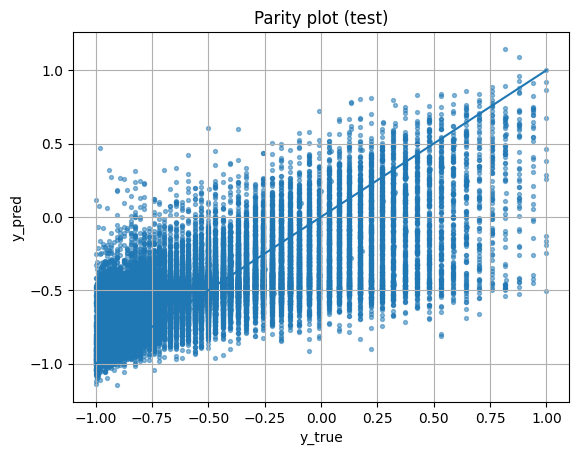

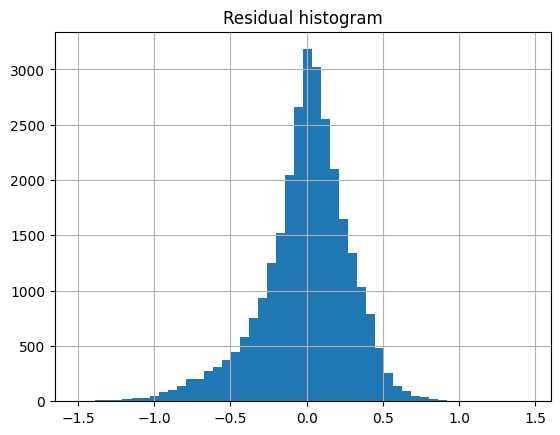

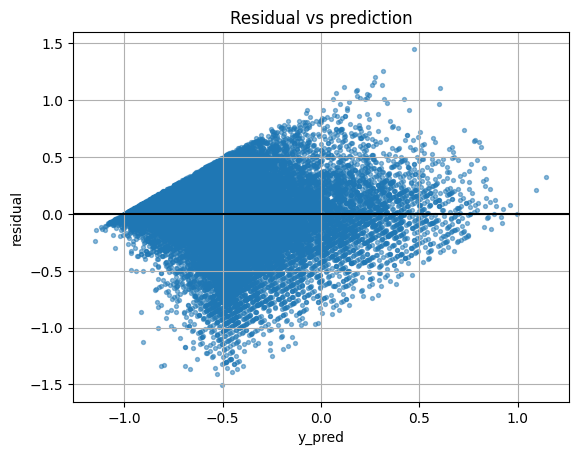

In [132]:
import matplotlib.pyplot as plt
import numpy as np

# 予測を収集
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for xb, yb in test_dl:
        y_true.append(yb.numpy())
        y_pred.append(model(xb.to(device)).cpu().numpy())
y_true = np.concatenate(y_true).ravel()
y_pred = np.concatenate(y_pred).ravel()

# パリティ
plt.figure(); plt.scatter(y_true, y_pred, s=8, alpha=0.5)
lim = (-1, 1); plt.plot(lim, lim)
# plt.xlim(lim); plt.ylim(lim)
plt.xlabel("y_true"); plt.title("Parity plot (test)"); plt.ylabel("y_pred"); plt.grid(True)

# 残差ヒスト
res = y_pred - y_true
plt.figure(); plt.hist(res, bins=50); plt.title("Residual histogram"); plt.grid(True)

# 残差 vs 予測
plt.figure(); plt.scatter(y_pred, res, s=8, alpha=0.5); plt.axhline(0,color='k')
plt.xlabel("y_pred"); plt.ylabel("residual"); plt.title("Residual vs prediction"); plt.grid(True)


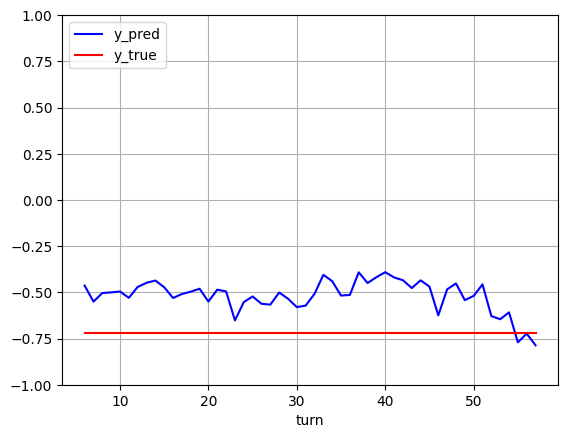

In [193]:
def predict_row(df_row):
    import numpy as np, torch
    x = df_row[feat_cols].to_numpy(dtype=np.float32).reshape(1, -1)
    xb = torch.from_numpy(x).to(device)
    model.eval()
    with torch.no_grad():
        y = model(xb).clamp(-1, 1).cpu().item()
    return y

def search_first(loc):
  ytrue = df.iloc[loc]["result"]
  first = loc
  while ytrue == df.iloc[first]["result"]:
    first -= 1
  return first + 1

def search_end(loc):
  ytrue = df.iloc[loc]["result"]
  first = loc
  while ytrue == df.iloc[first]["result"]:
    first += 1
  return first

loc = np.random.randint(0, len(df))
# while(df.iloc[loc]["result"] < 0.5):
#   loc = np.random.randint(0, len(df))

loc_first = search_first(loc); loc_end = search_end(loc)

yhat = [predict_row(df.iloc[loc]) for loc in range(loc_first, loc_end)]
ytrue = [df.iloc[loc]["result"] for loc in range(loc_first, loc_end)]
turns = [6 + idx for idx in range(0, loc_end - loc_first)]


plt.figure()
plt.plot(turns, yhat, color="b", label="y_pred"); plt.plot(turns, ytrue, color="r", label="y_true")
plt.legend(loc="upper left")
plt.ylim(-1, 1); plt.grid(True)
plt.xlabel("turn"); plt.show()

In [194]:
if 'best_state' in globals() and best_state is not None:
    model.load_state_dict(best_state)

model_cpu = model.to('cpu').eval()

W1 = model.fc1.weight.detach().numpy().astype(np.float32)
b1 = model.fc1.bias.detach().numpy().astype(np.float32)
W2 = model.fc2.weight.detach().numpy().astype(np.float32)
b2 = model.fc2.bias.detach().numpy().astype(np.float32)
Wo = model.out.weight.detach().numpy().astype(np.float32)   # shape [1,H2]
bo = model.out.bias.detach().numpy().astype(np.float32)     # shape [1]

D  = W1.shape[1]
H1 = W1.shape[0]
H2 = W2.shape[0]

In [196]:
out_dir = Path("/content/export")


def dump_line(f, arr):
    f.write(" ".join(f"{x:.9g}" for x in arr.ravel()) + "\n")

path_w1 = out_dir / "weights.txt"
with open(path_w1, "w", encoding="utf-8") as f:
  f.write(f"{D} {H1} {H2}\n")
  dump_line(f, W1)
  dump_line(f, b1)
  dump_line(f, W2)
  dump_line(f, b2)
  dump_line(f, Wo)
  dump_line(f, bo)